# Erste Anwendung 

- Die Idee ist, dass ich jetzt einen ersten Versuch des Ansatzes ausprobiere, bei dem ich ein strukturierten und einen unstrukturierten Teil einer Deep DL Modells über eine Optimierung einer unterstellten Gewichtungskostenfunktion.
- Ein weiterer Punkt ist es, die machbarkeit einer Optimierung über Tensorflow interne Methoden zu gewährleisten.


__[[toc]]__

____

## Vorgehen

1. Simulation von Daten
2. Aufstellen der Kostenfunktino
3. Fitten der Modelle
4. Berechnung der Degrees of Freedom
5. Aufstellung aller benötigter Größen
6. Optimierung der Kostenfunktion hinsichtich der Bedingungen

____

# 1. Simulation von Daten

Da das Ziel es ist eine Kombination zweier Modellteile zu einem gemeinsamen Model-Predictor, werden die Beobachtung durch einen Datengenerieredenden Prozess erstellt, welche insich eine Kombination von zwei einzelnen Datengeneriereden Prozessen ist.
Die Modellgleichung für den Prozess sein wie folgt:
$$
    y(w) = w_1 y_1 + w_2 y_2 + noise 
$$
das unterstellte Gewichtspaar $(w_1, w_2)$ ist festgelegt als $(\dfrac{1}{3}, \dfrac{2}{3})$ und der Noise als $noise \sim N(0, 1)$. 

Die teilgenerierenden Prozesse $(y_1 : \text{Lineares Modell}, y_2 : \text{Neuronales Netz})$ sein wie folgt definiert

\begin{align*}
    & y_1 = \beta_0 + \beta_1 x^{(1)}_1 \\
    & y_2 = \eta_0 + \eta_1 x^{(2)}_1 + \eta_2 x^{(2)}_2
\end{align*}

Die Inputs für beide Prozesse $(X^{(1)}, X^{(2)})$ sind dabei wie folgt verteilt $X^{(i)} \sim U(0,1)$. Die Werte für die Parameter sein wie folgt $\beta = (1, 3)$ und $\eta = (1, 2, 4)$


Der zusammengesetzte Prozess nimmt also die folgende Form an
\begin{equation*}
    y(w) = w_1 \cdot ( \beta_0 + \beta_1 x^{(1)}_1 ) + w_2 \cdot (\eta_0 + \eta_1 x^{(2)}_1 + \eta_2 x^{(2)}_2)
\end{equation*}



In [1]:
# Library
import random
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
import pandas as pd # weil numpy einmal wieder nicht matrix multiplikationen machen will ...

In [2]:
np.random.seed(42)

In [3]:
# Anzahl Beobachtungen:
n = 200
# Gewichte (w):
w = np.array((1/3, 2/3))
# Noise (noise):
noise = np.random.normal(loc=0.0, scale=1.0, size=n)
noise = noise.reshape(n, 1)
# Inputs berechnen:
X1 = np.random.uniform(low=0.0, high=1.0, size=n)
X1 = X1.reshape(n)
X2 = np.random.uniform(low=0.0, high=1.0, size=(n * 2))
X2 = X2.reshape(n, 2)
# beta1 (b):
beta = np.array((3))
# eta1 und eta2 (e1, e2):
eta = np.array((2, 4))
eta = eta.reshape(2, 1)
# y1 berechnen (y1):
y_1 = 1 + X1 * beta
y1 = w[0]*y_1
y1 = y1.reshape(n , 1)
# y2 berechnen (y2):
y_2 = 1 + np.matmul(X2, eta)
y2 = w[1]*y_2
# Zusammengesetzte Beobachtungen (Y):
Y = y1 + y2 + noise

# 2. Aufstellen der Kostenfunktion

Die Kostenfunktion welche wir unterstellen nimmt die folgende Form an 
$$
    C(w) = || y - y(w) ||^2 + 2 \sigma^2 w^{T} \rho,
$$

wobei $\rho$ als Vektor der Gewichte zu verstehen sei. Für $\sigma^2$ wird die Varianz des Modells mit den geringeren Degrees of Freedom genutzt.

In [4]:
def costfunction(y, yhat_1, yhat_2, w, sigma2, rho):
    """
    y : Beobachtungen, yhat_i : Gefittete y durch Model i
    w : initiale gewichte, sigma2 : unterstellte Varianz, rho : vektor dfs.
    """
    n = len(y)
    yhat_temp = np.column_stack((yhat_1, yhat_2))
    yhat_temp = yhat_temp.reshape(n, 2)
    temp_fit = LA.norm(Y - np.matmul(yhat_temp, w))
    cw = temp_fit**2 + 2 * sigma2 * np.matmul(w.transpose(), rho)
    return cw

____

# 3. Fitten der Modelle

Im ersten Durchgang auf jedes der X Datensätze jeweils ein Modell anwenden. Auf `X1` wird ein nornales Lineares Regressions Model in Form eines Neuronalen Netzes OHNE Hidden Layer angepasst. Auf `X2` wird ein Neuronales Netz mit zwei Hidden Layer mit jeweils 10 Hidden Units angepasst. Hierbei werden relu Aktivierungsfunktionen genutzt und in dem Output Layer eine Lineare Aktivierungsfunktion.

_____

## Set-Up Tensorflow

In [5]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

Init Plugin
Init Graph Optimizer
Init Kernel


In [6]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(
        learning_rate=0.1, momentum=0.0, nesterov=False, name='SGD'
        )

____

## Strukturierten Teil

In [7]:
reg_model = tf.keras.Sequential()
reg_model.add(tf.keras.layers.Dense(1, activation='linear', batch_input_shape=(None, 1)))
reg_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
history = reg_model.fit(X1, Y, epochs = 500, batch_size = n, verbose = 0)
y1_hat = reg_model.predict(X1)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-15 15:56:31.699263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-15 15:56:31.699408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-15 15:56:31.746472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-15 15:56:31.746654: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-15 15:56:31.888375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 15:56:33.161000: I tensorflow/core/grappler/

In [8]:
reg_model.get_weights()

[array([[1.4480865]], dtype=float32), array([2.8279226], dtype=float32)]

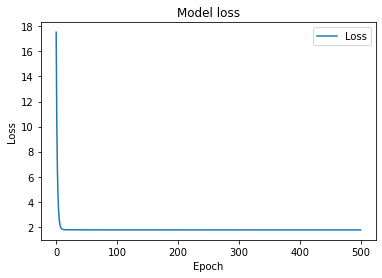

In [9]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper right')
plt.show()

____

## Neuronales Netz

In [49]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',
)

In [50]:
ann_model = tf.keras.Sequential()
ann_model.add(tf.keras.layers.Dense(10, activation='relu', batch_input_shape=(None, 2)))
ann_model.add(tf.keras.layers.Dense(1, activation='linear'))
ann_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
history = ann_model.fit(X2, Y, epochs = 1000, batch_size = n, verbose = 0)
y2_hat = ann_model.predict(X2)


2022-02-15 17:21:15.551792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 17:21:18.905775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


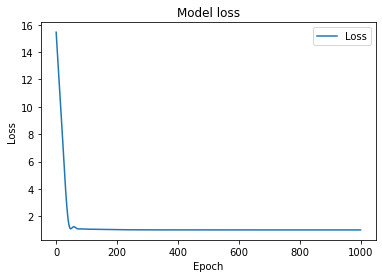

In [51]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper right')
plt.show()

____

# 4. Berechnung der Degrees of Freedom 

Diese "Berechnung" wird zwei mal gemacht. Einmal werden die Degrees of Freedom numerisch über die Finite Difference Methode bestimmt und einmal werden die theoretischen Degrees of Freedom genutzt.

____

## 4.1 Theoretische Degrees of Freedom

Bisherige Simulationen haben gezeigt, dass im Falle eines Regressionsproblemes mit bekannter Varianz die Degrees of Freedom gleich der Anzahl der Inputs ist. Die Theoretischen DFs sind also hier einfach $Input == DF$.

Die theoretischen DFs werden absofort als `tdf_m...` bezeichnet.

In [13]:
tdf_m1 = 2.0
tdf_m2 = 3.0
tdf = np.array((tdf_m1, tdf_m2))
tdf = tdf.reshape(2, 1)

_____

## 4.2. Numerische Degrees of Freedom

In [14]:
h = 1e-3
random.seed(42)
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(
        learning_rate=0.1, momentum=0.0, nesterov=False, name='SGD'
        )

### 4.2.1. Finite Differenzes Model 1

In [15]:
## Forward Modelle
y_iter = []
gewichte_m = []
fits = []
for i in tqdm(range(0,n)):
    temp_y = copy.deepcopy(Y)
    temp_y[i] += h
    y_iter.append(temp_y)
    random.seed(42)
    tf.random.set_seed(42)
    opt = tf.keras.optimizers.SGD(
            learning_rate=0.1, momentum=0.0, nesterov=False, name='SGD'
        )
    random.seed(42)
    tf.random.set_seed(42)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
    hist = model.fit(X1, temp_y, epochs = 500, batch_size=n, use_multiprocessing=True, verbose=0)
    temp_pred = model.predict(X1)
    fits.append(temp_pred[i])
fits_f = copy.deepcopy(np.array(fits))

## Backward Modelle
y_iter = []
gewichte_m = [ ]
fits = []
for i in tqdm(range(0,n)):
    temp_y = copy.deepcopy(Y)
    temp_y[i] -= h
    y_iter.append(temp_y)
    random.seed(42)
    tf.random.set_seed(42)
    opt = tf.keras.optimizers.SGD(
            learning_rate=0.1, momentum=0.0, nesterov=False, name='SGD'
            )
    random.seed(42)
    tf.random.set_seed(42)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
    hist = model.fit(X1, temp_y, epochs = 500, batch_size=n, use_multiprocessing=True, verbose=0)
    temp_pred = model.predict(X1)
    fits.append(temp_pred[i])
fits_b = copy.deepcopy(np.array(fits))

# Differenzen ausrechnen
forwdf = (np.sum((fits_f - y2_hat) / h))
backdf = (np.sum((y2_hat - fits_b) / h))
centdf = (np.sum((fits_f - fits_b) / (2 * h)))

  0%|          | 0/200 [00:00<?, ?it/s]2022-02-15 15:56:35.454461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 15:56:36.653436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
  0%|          | 1/200 [00:01<04:17,  1.29s/it]2022-02-15 15:56:36.744523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 15:56:37.929686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
  1%|          | 2/200 [00:02<04:13,  1.28s/it]2022-02-15 15:56:38.019673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 15:56:39.209810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_reg

In [18]:
print( "\nCentered Differences: ", centdf)


Centered Differences:  1.9984245


### 4.2.2. Finite Differenzes Model 2

In [31]:
## Forward Modelle
y_iter = []
gewichte_m = []
fits = []
for i in tqdm(range(0,n)):
    temp_y = copy.deepcopy(Y)
    temp_y[i] += h
    y_iter.append(temp_y)
    random.seed(42)
    tf.random.set_seed(42)
    opt = tf.keras.optimizers.Adam(
        learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam',
    )
    random.seed(42)
    tf.random.set_seed(42)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(10, activation='relu', batch_input_shape=(None, 2)))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
    hist = model.fit(X2, temp_y, epochs = 500, batch_size=n, use_multiprocessing=True, verbose=0)
    temp_pred = model.predict(X2)
    fits.append(temp_pred[i])
fits_f = copy.deepcopy(np.array(fits))

## Backward Modelle
y_iter = []
gewichte_m = [ ]
fits = []
for i in tqdm(range(0,n)):
    temp_y = copy.deepcopy(Y)
    temp_y[i] -= h
    y_iter.append(temp_y)
    random.seed(42)
    tf.random.set_seed(42)
    opt = tf.keras.optimizers.Adam(
        learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam',
    )
    random.seed(42)
    tf.random.set_seed(42)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(10, activation='relu', batch_input_shape=(None, 2)))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
    hist = model.fit(X2, temp_y, epochs = 500, batch_size=n, use_multiprocessing=True, verbose=0)
    temp_pred = model.predict(X2)
    fits.append(temp_pred[i])
fits_b = copy.deepcopy(np.array(fits))

# Differenzen ausrechnen
forwdf2 = (np.sum((fits_f - y2_hat) / h))
backdf2 = (np.sum((y2_hat - fits_b) / h))
centdf2 = (np.sum((fits_f - fits_b) / (2 * h)))

  0%|          | 0/200 [00:00<?, ?it/s]2022-02-15 16:37:53.424562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 16:37:55.135731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
  0%|          | 1/200 [00:01<06:14,  1.88s/it]2022-02-15 16:37:55.300123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 16:37:56.992517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
  1%|          | 2/200 [00:03<06:09,  1.87s/it]2022-02-15 16:37:57.156693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 16:37:58.873692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_reg

In [34]:
print("Centered Differences: ", centdf2)

Centered Differences:  2.9962063


____

# 5. Aufstellung der benötigten Größen

In [57]:
# Sigma^2 
sigma2 = 1.0
# dfs
dfs = np.array((centdf, centdf2))
# initialisierung der gewichte
w = np.array((0.5, 0.5))
# yhat_1, yhat_2
yhat_1 = y1_hat
yhat_2 = y2_hat

____

# 6. Optimierung des Kriteriums

Hierbei schaue ich mir vier verschiedene Fälle an.

1. Baseline: "Wahren" Wert, theoretische DFs und theoretische Varianz, "wahre" Gewichtung
2. Einfluss numerische DFs, siehe 1, nur mit numerisch bestimmten Degrees of Freedom
3. Einfluss der Modell fits, anstatt der optimalen Werte. Rest optimale/theoretische Werte.
4. Numerischer Wert, alles numerisch bestimmen

______

## 6.1 Baseline Kostenfunktionswerte

Theoretischer Wert der Varianz: `1.0` <br>
Theoretischer Wert der Degrees of Freedom: $\rho = (\dfrac{1}{3}, \dfrac{2}{3})$ <br>
Theoretisch bester Fit: Model 1: $\hat{y} = y_1$ und Model 2: $\hat{y} = y_2$

In [36]:
gewichte = np.array((1/3, 2/3))
gewichte = gewichte.reshape(2, 1)

### 6.1.1 Baseline optimaler Werte

In [37]:
print("Optimaler Wert der Kostenfunktion: ", costfunction(y = Y, yhat_1=y_1, yhat_2=y_2, sigma2=1.0, w=gewichte, rho=tdf)[0][0])

Optimaler Wert der Kostenfunktion:  186.38035066136663


_____

### 6.1.2 Numerische DFs

Nutzen der numerisch bestimmten Degrees of Freedom beider Modelle. <br>
Rest der Werte sind optimale und stammen aus 6.1.

In [40]:
dfs = dfs.reshape(2, 1)
print(dfs)

[[1.9984245]
 [2.9962063]]


In [60]:
print("Wert der Kostenfunktion: ", costfunction(y = Y, yhat_1=y_1, yhat_2=y_2, sigma2=1.0, w=gewichte, rho=tdf)[0][0])

Wert der Kostenfunktion:  186.38035066136663


____

### 6.1.3  Modelfit Werte

In [63]:
print("Wert der Kostenfunktion: ", costfunction(y = Y, yhat_1=yhat_1, yhat_2=yhat_2, sigma2=1.0, w=gewichte, rho=tdf)[0][0])

Wert der Kostenfunktion:  210.58732097609226


___ 

### 6.1.4 Numerische Werte, gegeben optimnaler Gewichtung

In [67]:
print("Wert der Kostenfunktion: ", costfunction(y = Y, yhat_1=yhat_1, yhat_2=yhat_2, sigma2=1.0, w=gewichte, rho=dfs))

Wert der Kostenfunktion:  [210.58121237]


_____

## 6.2. Optimierung der Gewichte


Gewichtsoptimierung in tensorflow, nachschauen hier: https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/contrib/constrained_optimization
Leider nur für tensorflow 1. Ähnlich hier: https://www.tensorflow.org/api_docs/python/tf/keras/constraints/Constraint
Funktioniert nur für eine Constraint. Muss also meine eigene schreiben.

- Thomas Idee anschauen=? Vielleicht kann man es einfach über die letzte Aktivierungsfunktion klären? Softmax???

_____

### 6.2.1 Externe Weight Optimization 